In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torchvision.models import resnet50
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import numpy as np
import torchvision.transforms.functional as F
import cv2
import random
import os

In [2]:

# image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load the datasets
dataset_path = './dataset-secondary'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
print(f'Classes: {class_names}')

Classes: ['batteries', 'soda']


In [4]:
# split dataset into train and test
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

labels = [full_dataset.targets[i] for i in range(len(full_dataset))]
labels = np.array(labels)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(np.zeros(len(labels)), labels):
    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

# data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Number of training samples: 369
Number of testing samples: 93


In [5]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Replace last fully connected layer
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\civip\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\civip\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Training loop
epochs = 10
print("Training started...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")

Training started...


c:\Users\civip\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10, Loss: 0.5030
Epoch 2/10, Loss: 0.2729
Epoch 3/10, Loss: 0.1828
Epoch 4/10, Loss: 0.1585
Epoch 5/10, Loss: 0.1128
Epoch 6/10, Loss: 0.0978
Epoch 7/10, Loss: 0.0792
Epoch 8/10, Loss: 0.0808
Epoch 9/10, Loss: 0.1182
Epoch 10/10, Loss: 0.0617
Training complete.


In [7]:
# Validation
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Testing Accuracy: {accuracy:.2f}%')

# Calculate F1-Score (Macro for Multi-class)
fscore = f1_score(true_labels, predicted_labels, average='micro')
print(f'F1-Score: {fscore:.4f}')

# Save model
torch.save(model.state_dict(), 'resnet50_battery_soda.pth')
print("Model saved.")

Testing Accuracy: 98.92%
F1-Score: 0.9892
Model saved.


              precision    recall  f1-score   support

     battery       0.99      1.00      0.99        72
        soda       1.00      0.95      0.98        21

    accuracy                           0.99        93
   macro avg       0.99      0.98      0.98        93
weighted avg       0.99      0.99      0.99        93



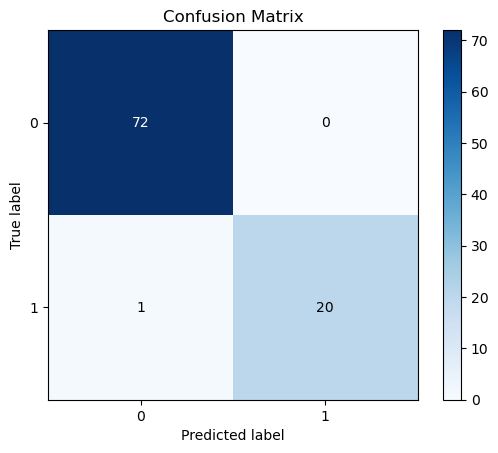

In [8]:
import scikitplot as skplt
from sklearn.metrics import classification_report

skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels, target_names=['battery', 'soda']))